In [1]:
#using DifferentialEquations
#using ADCME
using Plots

In [74]:
function f_hi(a, T, R)
        v1 = (a[:,2] + a[:,3] * T + a[:,4] * T^2 + a[:,5] * T^3 + a[:,6] * T^4) * R
        v2 = (a[:,2] + a[:,3] * T / 2 + a[:,4] * T^2 /3 + a[:,5] * T^3 /4 + a[:,6] * T^4 /5 + a[:,7] / T) * R * T
        v3 = (a[:,2] * log(T) + a[:,3] * T + a[:,4] * T^2 /2 + a[:,5] * T^3 /3 + a[:,6] * T^4 / 4 + a[:,8]) * R
    return [v1 v2 v3]
end
 
function f_lo(a, T, R)
    v1 = (a[:,9] + a[:,10] * T + a[:,11] * T^2 + a[:,12] * T^3 + a[:,13] * T^4) * R
    v2 = (a[:,9] + a[:,10] * T / 2 + a[:,11] * T^2 /3 + a[:,12] * T^3 /4 + a[:,13] * T^4 /5 + a[:,14]/T) * R * T
    v3 = (a[:,9] * log(T) + a[:,10] * T + a[:,11] * T^2 /2 + a[:,12] * T^3 /3 + a[:,13] * T^4 / 4 + a[:,15]) * R
    return [v1 v2 v3]
end 

function compute_falloff(T, pr, a)
    fcent = (1 - a[1]) * exp(-T/a[2]) + a[1] * exp(-T/a[3]) + exp(-a[4]/T)
    c = -0.4 - 0.67 * log(10, fcent)
    n = 0.75 - 1.27 * log(10, fcent)
    f1 = (log(10, pr) + c) / (n - 0.14 *(log(10, pr) + c))
    return  10 ^ (log(10, fcent) / (1 + f1 ^ 2))
end

compute_falloff (generic function with 1 method)

In [75]:
using PyCall
#### Read data
py"""
import numpy as np
"""

In [76]:
V = 1  # Volume
m_ = (py"np.load"("data/density.npy"))[1] # Total mass
tbd = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy") .+ 1
tbd = Int.(tbd)
falofr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy") .+ 1
falofr = Int.(falofr)
elmr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy") .+ 1
elmr = Int.(elmr)
NASA_coeffs = py"np.load"("data/NASA_coeffs.npy")
W = py"np.load"("data/molecular_weights.npy") # Molar weight
ν1 = py"np.load"("data/reactants_stoich_coeffs.npy") # Forward molar stoichiometric coefficients
ν2 = py"np.load"("data/product_stoich_coeffs.npy") # Backward model stoichiometric coefficients
reversible = py"np.load"("data/reversible.npy")
N = size(ν1)[1]  # Number of Species
M = size(ν1)[2]  # Number of Reactions
ν1_order = zeros(N,M)
ν = ν2 - ν1  
pa = 100000 # 1 bar
R = 8314.4621 # Gas constant in kmol
### Constants: Combustion Chamber Level
Yin = ones(N) # Mass fraction of species entering the chamber
Yout = ones(N) # Mass fraction of species leaving the chamber
Qdot = 0 # Heating source
hin = 1 # Enthalpy of input
### Unknowns
Tt_cant = py"np.load"("data/temperature.npy")
T = Tt_cant[1] # Temperature
Y = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy") # Mass fractions
### Quantities that depend on the Unknowns
order = py"np.load"("data/reaction_orders.npy")
Af = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor.npy") # preexponential constant Afj
β = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent.npy") # Temperature exponent
E = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy.npy") # Activation energy for the reactions in kJ

order_t = py"np.load"("data/reaction_orders_t.npy")
efficiency_t = py"np.load"("data/efficiency_t.npy")
Af_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_t.npy") # preexponential constant Afj
β_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_t.npy") # Temperature exponent
E_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_t.npy") # Activation energy for the reactions in kJ

order_f = py"np.load"("data/reaction_orders_f.npy")
troefall = py"np.load"("data/troefall.npy") .+ 1
troefall_coeff = py"np.load"("data/troefall_coeff.npy")
efficiency_f = py"np.load"("data/efficiency_f.npy")
Af_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_hi.npy") # preexponential constant Afj
β_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_hi.npy") # Temperature exponent
E_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_hi.npy") 

Af_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_lo.npy") # preexponential constant Afj
β_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_lo.npy") # Temperature exponent
E_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_lo.npy") 

ν1_order[:,elmr] = order
ν1_order[:,tbd] = order_t
ν1_order[:,falofr] = order_f


function q(t)
    t0 = 1e-5
    r = 1e-6
    c = 5e11
    return c * exp(-(t-t0)^2 / r^2)
end

function f(mTY, t)
    m = mTY[1]
    T = mTY[2]
    Y = mTY[3:end]
    ρ = m / V # density
    X = ρ * Y ./ W # Concentration
    Q = ones(M) # Individual progress rates
    islarge = NASA_coeffs[:,1] .< T * ones(N)
    fhi = f_hi(NASA_coeffs, T, R)
    flo = f_lo(NASA_coeffs, T, R)
    cp = islarge .* fhi[:,1] + (1 .- islarge) .* flo[:,1]
    h = islarge .* fhi[:,2] + (1 .- islarge) .* flo[:,2]
    s = islarge .* fhi[:,3] + (1 .- islarge) .* flo[:,3]
    cvk = cp .- R
    ΔS = ν' * s  # Entropy change for reaction j
    ΔH = ν' * h # Entahlpy change for reaction j
    ####
    M_t = efficiency_t' * X
    Kf_t = Af_t .* (T .^ β_t) .* exp.(-E_t ./ (R * T)) .* M_t
    Kr_t = Kf_t ./ (((pa/(R * T)) .^ sum(ν[:,tbd], dims=1)' .* exp.(ΔS[tbd] ./ R - ΔH[tbd] ./ (R * T))))
    Qtbd = Kf_t .* prod(X .^ order_t, dims=1)' .- Kr_t .* prod(X .^ ν2[:,tbd], dims=1)' .* reversible[tbd]
    ####
    M_f = efficiency_f' * X
    Kf_lo = Af_lo .* (T .^ β_lo) .* exp.(-E_lo ./ (R * T)) .* M_f
    Kf_hi = Af_hi .* (T .^ β_hi) .* exp.(-E_hi ./ (R * T)) 
    Pr = Kf_lo ./ Kf_hi
    Fac = ones(size(falofr)[1])
    Fac[troefall] = [compute_falloff(T, Pr[s], troefall_coeff[:,i]) for (i,s) in enumerate(troefall)]
    Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
    Kr_f = Kf_f ./ (((pa/(R * T)) .^ sum(ν[:,falofr], dims=1)' .* exp.(ΔS[falofr] ./ R - ΔH[falofr] ./ (R * T))))
    Qfalofr = Kf_f .* prod(X .^ order_f, dims=1)' .- Kr_f .* prod(X .^ ν2[:,falofr], dims=1)' .* reversible[falofr]
    ####
    Kf = Af .* (T .^ β) .* exp.(-E ./ (R * T))
    Kr = Kf ./ (((pa/(R * T)) .^ sum(ν[:,elmr], dims=1)' .* exp.(ΔS[elmr] ./ R - ΔH[elmr] ./ (R * T))))
    Qelmr = Kf .* prod(X .^ order, dims=1)' .- Kr .* prod(X .^ ν2[:,elmr], dims=1)' .* reversible[elmr]
    ##### Computing ω_dot 
    cv = sum(cvk ./ W .* Y) # Mass heat capacities
    u = h ./ W - R ./ W .* T   # Internal energy for species
    p = sum(X) * R * T # pressure
    Q = [Qtbd' Qfalofr' Qelmr']
    ν_new = [ν[:,tbd] ν[:,falofr] ν[:,elmr]]
    ω_dot = W .* sum(ν_new .* Q, dims=2)
    ###### mout_dot computation
    cp_total = sum(cp ./ W .* Y)
    _area = 1
    _gamma_s = cp_total / cv
    _press = sum(X) * R * T
    _r_gas_specific = cp_total - cv
    _p_ratio = 101325 / (_press + 1.0)
    power_1 = 2.0 / _gamma_s
    power_2 = (_gamma_s + 1.0) / (_gamma_s)
    pressure_term = _p_ratio ^ power_1 - _p_ratio ^ power_2
    _sqrt_term = 2. * _gamma_s * _r_gas_specific * T / (_gamma_s - 1.0)
    _sqrt_term *= pressure_term
    _sqrt_term = (_sqrt_term)^(0.5)

    _mdot_unchoked = m * _area * _sqrt_term

    power = (_gamma_s + 1.0) / (_gamma_s - 1.0)
    _gamma_term = (2. / (_gamma_s + 1.0)) ^ power
    _sqrt = (_gamma_s * _r_gas_specific * T * _gamma_term)^(0.5)
    _mdot_choked = m * _area * _sqrt
    _p_crit_downstream = _press * (2. / (_gamma_s + 1.0)) ^ (_gamma_s / (_gamma_s - 1.0))
    if (_p_crit_downstream < 101325)
        mout_dot = _mdot_unchoked
    else
        mout_dot = _mdot_choked
    end
    ###### Species Conservation
    mgen_dot = V .* ω_dot
    min_dot = 0
    m_dot = min_dot - mout_dot
    Y_dot = (1 / m) .* (min_dot .* (Yin .- Y) .+ mgen_dot) 
    ###### Energy Conservation
    T_dot = 1 / (m * cv) * (q(t) + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))
    return [m_dot; T_dot; Y_dot]
end

f (generic function with 1 method)

In [77]:
X = (m_ / V) * Y ./ W
Pt[1] = sum(X) * R * T

105000.00000000001

In [78]:
## RK4
#dt = 4e-9
timestep = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/timestep.npy")
n_t = size(timestep)[1]
#n_t = 2000
T = Tt_cant[1] # Temperature
Y = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy") # Mass fractions
mTY = [m_;T;Y]
TYt = zeros(N+1, n_t)
Tt = zeros(n_t)
Pt = zeros(n_t)
Yt = zeros(N,n_t)
mt = zeros(n_t)
mt[1] = m_
Y0 = copy(Y)
Yt[:,1] .= Y
Tt[1] = T
X = (m_ / V) * Y ./ W
Pt[1] = sum(X) * R * T
for i = 1:n_t - 1
    dt = timestep[i+1] - timestep[i]
    k1 = f(mTY, timestep[i])
    k2 = f(mTY + 0.5 * dt * k1, timestep[i] + 0.5 * dt)
    k3 = f(mTY + 0.5 * dt * k2, timestep[i] + 0.5 * dt)
    k4 = f(mTY + dt * k3, timestep[i] + dt)
    mTY += 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    #TY += dt * f(TY,timestep[i])
    Tt[i+1] = mTY[2]
    println(mTY[2])
    println(i)
    Y = mTY[3:end]
    mt[i + 1] = mTY[1]
    Yt[:,i+1] = Y
    X = (mTY[1] / V) * Y ./ W
    TYt[:,i+1] = mTY[2:end]
    Pt[i+1] = sum(X) * R * mTY[2]
end

500.00071132985255
1
500.001422718126
2
500.00213416482137
3
500.00284566993975
4
500.0035572334823
5
500.00426885545005
6
500.0049805358441
7
500.0056922746655
8
500.0064040719153
9
500.0071159275947
10
500.00782784170474
11
500.00853981424643
12
500.00925184522094
13
500.0099639346293
14
500.0106760824726
15
500.011388288752
16
500.0121005534685
17
500.0128128766232
18
500.01352525821716
19
500.01423769825146
20
500.0149501967272
21
500.01566275364553
22
500.01637536900745
23
500.017088042814
24
500.01780077506635
25
500.01851356576555
26
500.0192264149127
27
500.01993932250883
28
500.020652288555
29
500.0213653130524
30
500.02207839600203
31
500.022791537405
32
500.02350473726233
33
500.02421799557516
34
500.02493131234456
35
500.0256446875716
36
500.0263581212574
37
500.02707161340294
38
500.02778516400934
39
500.02849877307773
40
500.0292124406091
41
500.02992616660464
42
500.0306399510653
43
500.03135379399225
44
500.03206769538656
45
500.03278165524927
46
500.03349567358146
47
5

2424.6103013977345
451
2428.859523185644
452
2432.535330382636
453
2435.710175906271
454
2438.4487913932276
455
2440.80851432123
456
2442.839785775494
457
2444.5867403446914
458
2446.0878318182936
459
2447.3764562310803
460
2448.4815475295673
461
2449.4281312599264
462
2450.2378288639693
463
2450.929310071525
464
2451.518694066407
465
2452.019902048307
466
2452.444964881598
467
2452.8042899921493
468
2453.106891750155
469
2453.360589410477
470
2453.5721763812758
471
2453.7475642376935
472
2453.8919045513812
473
2454.009691314113
474
2454.104846523327
475
2454.180791375406
476
2454.240505456505
477
2454.286576279177
478
2454.32124141647
479
2454.346425271506
480
2454.3637721645077
481
2454.374676950064
482
2454.380313871439
483
2454.38166390826
484
2454.37954055063
485
2454.374613764214
486
2454.367431880913
487
2454.3584412147397
488
2454.3480033130436
489
2454.336409869018
490
2454.323895417721
491
2454.3106480043684
492
2454.2968180502307
493
2454.2825256532433
494
2454.2678665544163

In [79]:
#X = [i * 4e-9 for i = 1:2000]
Yt_cant = py"np.load"("data/mass_fraction.npy")
plot(timestep, Yt')
#plot!(X,  Yt_cant')
xlabel!("Time")
ylabel!("Mass Fractions")
savefig("Mass_fraction.pdf")

In [80]:
plot(timestep, (Yt ./ sum(Yt, dims = 1))')
xlabel!("Time")
ylabel!("Mass Fractions")
savefig("Mass_fraction.pdf")

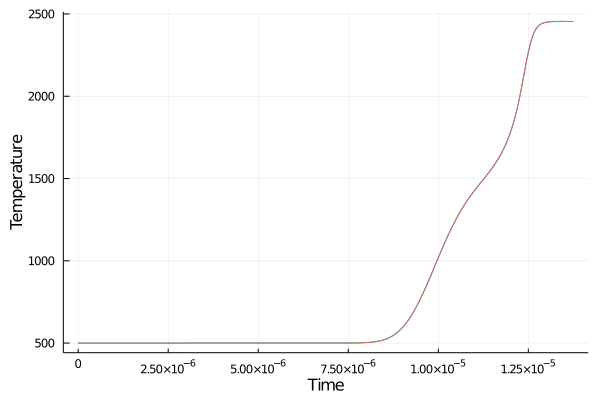

In [81]:
#X = [i * 4e-9 for i = 1:2000]
Tt_cant = py"np.load"("data/temperature.npy")
plot(timestep, Tt, label =false)
plot!(timestep, Tt_cant, label =false)
xlabel!("Time")
ylabel!("Temperature")
#savefig("Temperature.pdf")

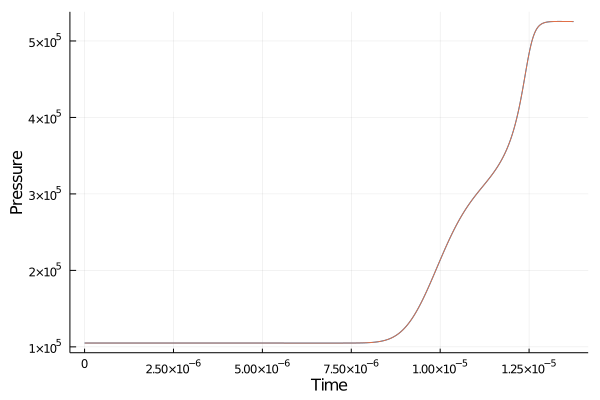

In [82]:
Pt_cant = py"np.load"("data/pressure.npy")
plot(timestep, Pt, label = false)
plot!(timestep, Pt_cant, label = false)
xlabel!("Time")
ylabel!("Pressure")
#savefig("Pressure.pdf")

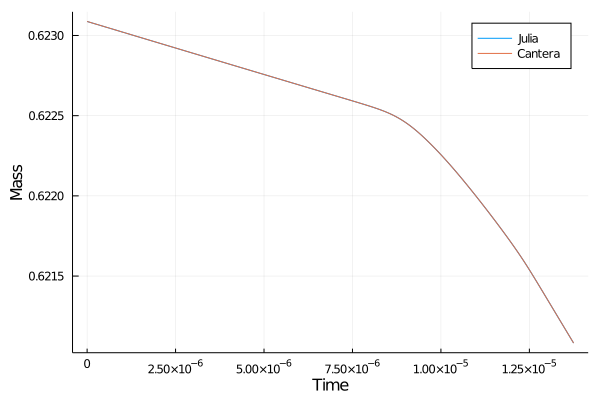

In [83]:
Rhot_cant = py"np.load"("data/total_mass.npy")

plot(timestep, mt, label = "Julia")
plot!(timestep, Rhot_cant,  label = "Cantera")
xlabel!("Time")
ylabel!("Mass")
#savefig("Mass.pdf")

In [ ]:
dt = 1e-12
for i = 1:n_t
    k1 = f(TY)
    k2 = f(TY + 0.5 * dt * k1)
    k3 = f(TY + 0.5 * dt * k2)
    k4 = f(TY + dt * k3)
    TY += 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    #TY += dt * f(TY)
    Tt[i] = TY[1]
    print(TY[1])
    println(i)
    Y = TY[2:end]
    Yt[:,i] = Y
    X = ρ * Y ./ W
    p = sum(X) * R * TY[1]
    TYt[:,i] = TY
    Pt[i] = p
end

In [ ]:
function forward!(dty, ty, p, t)
    T = ty[1]
    Y = ty[2:end]
    ρ = m / V # density
    X = ρ * Y ./ W # Concentration
    Q = ones(M) # Individual progress rates
    # cpHS = compute_cpHS(NASA_coeffs, R, T)
    # cp = cpHS[:,1]
    # h = cpHS[:,2]
    # s = cpHS[:,3]
    #islarge = NASA_coeffs[:,1] .< T * ones(N)
    fhi = f_hi(NASA_coeffs, T, R)
    #flo = f_lo(NASA_coeffs, T, R)
    
#     cp = islarge .* fhi[:,1] + (1 .- islarge) .* flo[:,1]
#     h = islarge .* fhi[:,2] + (1 .- islarge) .* flo[:,2]
#     s = islarge .* fhi[:,3] + (1 .- islarge) .* flo[:,3]
    cp = fhi[:,1] 
    h = fhi[:,2] 
    s = fhi[:,3] 
    cvk = cp .- R
    ΔS = ν' * s  # Entropy change for reaction j
    ΔH = ν' * h # Entahlpy change for reaction j
    ####
    M_t = efficiency_t' * X
    Kf_t = Af_t .* (T .^ β_t) .* exp.(-E_t ./ (R * T)) .* M_t
    Kr_t = Kf_t ./ (((pa/(R * T)) .^ sum(ν[:,tbd], dims=1)' .* exp.(ΔS[tbd] ./ R - ΔH[tbd] ./ (R * T))))
    Qtbd = Kf_t .* prod(X .^ order_t, dims=1)' .- Kr_t .* prod(X .^ ν2[:,tbd], dims=1)' .* reversible[tbd]
    ####
    M_f = efficiency_f' * X
    Kf_lo = Af_lo .* (T .^ β_lo) .* exp.(-E_lo ./ (R * T)) .* M_f
    Kf_hi = Af_hi .* (T .^ β_hi) .* exp.(-E_hi ./ (R * T)) 
    Pr = Kf_lo ./ Kf_hi
    Fac = ones(size(falofr)[1])
    Fac[troefall] = [compute_falloff(T, Pr[s], troefall_coeff[:,i]) for (i,s) in enumerate(troefall)]
    Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
    Kr_f = Kf_f ./ (((pa/(R * T)) .^ sum(ν[:,falofr], dims=1)' .* exp.(ΔS[falofr] ./ R - ΔH[falofr] ./ (R * T))))
    Qfalofr = Kf_f .* prod(X .^ order_f, dims=1)' .- Kr_f .* prod(X .^ ν2[:,falofr], dims=1)' .* reversible[falofr]
    ####
    Kf = Af .* (T .^ β) .* exp.(-E ./ (R * T))
    Kr = Kf ./ (((pa/(R * T)) .^ sum(ν[:,elmr], dims=1)' .* exp.(ΔS[elmr] ./ R - ΔH[elmr] ./ (R * T))))
    Qelmr = Kf .* prod(X .^ order, dims=1)' .- Kr .* prod(X .^ ν2[:,elmr], dims=1)' .* reversible[elmr]
    ##### Computing ω_dot 
    cv = sum(cvk ./ W .* Y) # Mass heat capacities
    u = h ./ W - R ./ W .* T   # Internal energy for species
    p = sum(X) * R * T # pressure
    Q = [Qtbd' Qfalofr' Qelmr']
    ν_new = [ν[:,tbd] ν[:,falofr] ν[:,elmr]]
    ω_dot = W .* sum(ν_new .* Q, dims=2)
    ###### Species Conservation
    mgen_dot = V .* ω_dot
    dty[2:end] = (1 / m) .* (min_dot .* (Yin .- Y) - mout_dot .* Y .+ mgen_dot) 
    ###### Energy Conservation
    dty[1] = 1 / (m * cv) * (-Qdot + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))
end

In [ ]:
TY = [T;Y]
u0 = TY
tspan = (0.0,0.001)
prob = ODEProblem(forward!,u0,tspan)
sol = DifferentialEquations.solve(prob)

In [ ]:
using ModelingToolkit
de = modelingtoolkitize(prob)